# LSTM Stock Price Prediction Model

## Overview
This notebook implements a Long Short-Term Memory (LSTM) neural network for stock price prediction using **5 key features** that are easy to understand and explain to stakeholders.

## The 5 Key Features

Instead of using only the closing price, our model uses 5 intuitive features:

1. **Close Price** - The actual stock closing price (our main target)
   - What it means: The final price at market close each day
   - Why it matters: Historical prices show trends and patterns

2. **Volume** - Number of shares traded
   - What it means: How many shares were bought/sold that day
   - Why it matters: High volume indicates strong interest/conviction in price moves

3. **20-Day Moving Average (MA20)** - Average price over last 20 days
   - What it means: Smoothed trend line showing general direction
   - Why it matters: Helps identify if stock is trending up or down

4. **Volatility** - How much the price fluctuates
   - What it means: Standard deviation of daily returns over 20 days
   - Why it matters: High volatility = risky/unpredictable, Low volatility = stable

5. **RSI (Relative Strength Index)** - Momentum indicator (0-100)
   - What it means: Measures if stock is overbought (>70) or oversold (<30)
   - Why it matters: Helps predict potential reversals in price direction

## Model Architecture

**Simplified LSTM Design:**
- **2 LSTM Layers** with 64 hidden units each
- **Bidirectional processing** - looks at patterns from both past and future
- **Dropout (20%)** - prevents overfitting to training data
- **Output layer** - predicts next day's closing price

**How it works:**
1. Takes the last 60 days of these 5 features as input
2. LSTM layers learn patterns in the sequential data
3. Outputs a prediction for the next day's closing price

## Why These 5 Features?

- **Price (Close)**: The fundamental data - what we're predicting
- **Volume**: Confirms whether price moves are strong or weak
- **MA20**: Shows the overall trend without daily noise
- **Volatility**: Captures risk and uncertainty in the market
- **RSI**: Identifies potential turning points (reversals)

These 5 features together give the model information about:
- **Trend** (MA20)
- **Momentum** (RSI)
- **Risk** (Volatility)
- **Conviction** (Volume)
- **Price History** (Close)

## Usage
1. Select a stock ticker (default: 'A')
2. Run all cells in order
3. Model trains automatically and shows results
4. Review visualizations to understand predictions

## Important Notes
- **Educational purposes only** - Not financial advice
- **Past performance does not equal future results**
- Model shows what patterns exist in historical data
- Real markets affected by news, earnings, global events not captured here

## Key Parameters
- `n_past = 60`: Uses last 60 days to predict next day
- `hidden_size = 64`: LSTM memory capacity
- `num_layers = 2`: Two LSTM layers
- `dropout = 0.2`: 20% dropout for regularization
- `batch_size = 32`: Training batch size
- `num_epochs = 50`: Training iterations


In [124]:
# Step 0: Import Libraries

import os
import math
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
plt.style.use("seaborn-v0_8")


In [125]:
# enable GPU is running the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [126]:
# Helper Functions for Feature Engineering and Sequence Creation

def calculate_features(df):
    """
    Calculate the 5 key features for stock prediction:
    1. Close - closing price
    2. Volume - trading volume
    3. MA20 - 20-day moving average
    4. Volatility - 20-day standard deviation of returns
    5. RSI - Relative Strength Index (14-day)
    """
    df = df.copy()
    
    # Feature 1: Close price (already in dataset)
    # Feature 2: Volume (already in dataset)
    
    # Feature 3: 20-day Moving Average
    df['MA20'] = df['Close'].rolling(window=20).mean()
    
    # Feature 4: Volatility (standard deviation of daily returns)
    df['Daily_Return'] = df['Close'].pct_change(fill_method=None)
    df['Volatility'] = df['Daily_Return'].rolling(window=20).std()
    
    # Feature 5: RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Drop the intermediate Daily_Return column (not needed as feature)
    df = df.drop('Daily_Return', axis=1)
    
    return df


def create_sequences_multivariate(data, feature_cols, target_col, n_past):
    """
    Create sequences for multivariate LSTM
    
    Args:
        data: DataFrame with all features
        feature_cols: list of column names to use as features
        target_col: name of target column to predict
        n_past: number of past time steps to use as input
    
    Returns:
        X: (num_samples, n_past, num_features)
        y: (num_samples,)
    """
    X, y = [], []
    
    feature_data = data[feature_cols].values
    target_data = data[target_col].values
    
    for i in range(n_past, len(data)):
        X.append(feature_data[i - n_past:i])
        y.append(target_data[i])
    
    return np.array(X), np.array(y)


In [127]:
# Paths relative to project root
DATA_ROOT = "../../data/archive"
Symbols_path = os.path.join(DATA_ROOT, "symbols_valid_meta.csv")

tickers_df = pd.read_csv(Symbols_path)

print("Meta columns:", tickers_df.columns.tolist())
print("Number of symbols in meta:", len(tickers_df))

# Example: A
# May change how to pick the symbol to be done on function call 

target_ticker = "A"

# Find symbol row
row = tickers_df[tickers_df["Symbol"] == target_ticker]
if row.empty:
    raise ValueError(f"Symbol {target_ticker} not found in metadata.")

is_etf = (row["ETF"].iloc[0] == "Y")
asset_type = "etfs" if is_etf else "stocks"

print(f"Selected symbol: {target_ticker} | ETF? {is_etf} | Folder: {asset_type}")


Meta columns: ['Nasdaq Traded', 'Symbol', 'Security Name', 'Listing Exchange', 'Market Category', 'ETF', 'Round Lot Size', 'Test Issue', 'Financial Status', 'CQS Symbol', 'NASDAQ Symbol', 'NextShares']
Number of symbols in meta: 8049
Selected symbol: A | ETF? False | Folder: stocks


In [128]:
#Load data of selected ticker
data_path = os.path.join(DATA_ROOT, asset_type, f"{target_ticker}.csv")
stock_df = pd.read_csv(data_path)
stock_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300.0
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100.0
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800.0
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600.0
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200.0


In [129]:
# Make sure there is a date column named "Date"
if "Date" not in stock_df.columns:
    if "date" in stock_df.columns:
        stock_df = stock_df.rename(columns={"date": "Date"})
    else:
        raise KeyError("Could not find a 'Date' or 'date' column in the CSV.")

# Ensure we have a closing price column named "Close"
if "Close" not in stock_df.columns:
    # Some datasets use "Adj Close" or "close"
    if "Adj Close" in stock_df.columns:
        stock_df = stock_df.rename(columns={"Adj Close": "Close"})
    elif "close" in stock_df.columns:
        stock_df = stock_df.rename(columns={"close": "Close"})
    else:
        raise KeyError("Could not find a 'Close', 'Adj Close', or 'close' column.")

# Convert Date to datetime and sort chronologically
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df = stock_df.sort_values("Date").reset_index(drop=True)

print("Date range:", stock_df["Date"].min().date(), "to", stock_df["Date"].max().date())

# Optional: restrict the time window (you can adjust these)
start_date = datetime(2014, 1, 1)
end_date   = stock_df["Date"].max()

mask = (stock_df["Date"] >= start_date) & (stock_df["Date"] <= end_date)
stock_df = stock_df.loc[mask].reset_index(drop=True)


stock_df[["Date", "Close"]].head()


Date range: 1999-11-18 to 2025-12-01


,Date,Close
0,2014-01-02,40.207439
1,2014-01-03,40.715309
2,2014-01-06,40.515022
3,2014-01-07,41.094421
4,2014-01-08,41.766811


In [130]:
# Prepare Dataset with 5 Key Features

# Add the 4 calculated features (Close and Volume already exist)
stock_df = calculate_features(stock_df)

# Drop rows with NaN values (from rolling windows)
stock_df = stock_df.dropna().reset_index(drop=True)

print(f"Data shape after feature engineering: {stock_df.shape}")
print(f"Available columns: {stock_df.columns.tolist()}")

# Select the 5 features for the model
feature_columns = [
    'Close',      # Feature 1: Historical closing prices
    'Volume',     # Feature 2: Trading volume
    'MA20',       # Feature 3: 20-day moving average (trend)
    'Volatility', # Feature 4: Price volatility (risk)
    'RSI'         # Feature 5: Relative Strength Index (momentum)
]

target_column = 'Close'

print(f"\n✓ Using {len(feature_columns)} features for prediction:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i}. {feat}")

# Extract data for scaling
dates = stock_df["Date"].values
feature_data = stock_df[feature_columns].values
target_data = stock_df[target_column].values.reshape(-1, 1)

# Scale features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(feature_data)
scaled_target = target_scaler.fit_transform(target_data)

# Chronological split: 80% train / 20% test
train_size = int(len(scaled_features) * 0.8)

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]

test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

print(f"\nTrain features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Number of past days to use for prediction
n_past = 60

# Create sequences directly from scaled data (no need to combine since Close is already in features)
train_df = pd.DataFrame(train_features, columns=feature_columns)
test_df = pd.DataFrame(test_features, columns=feature_columns)

X_train, y_train = create_sequences_multivariate(train_df, feature_columns, target_column, n_past)
X_test, y_test = create_sequences_multivariate(test_df, feature_columns, target_column, n_past)

print(f"\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Features per timestep: {X_train.shape[2]}")


Data shape after feature engineering: (2977, 10)
Available columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA20', 'Volatility', 'RSI']

✓ Using 5 features for prediction:
  1. Close
  2. Volume
  3. MA20
  4. Volatility
  5. RSI

Train features shape: (2381, 5)
Test features shape: (596, 5)

X_train: (2321, 60, 5), y_train: (2321,)
X_test: (536, 60, 5), y_test: (536,)
Features per timestep: 5


In [131]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)


In [132]:
# Simplified LSTM Model

class StockLSTM(nn.Module):
    """
    Simple LSTM model for stock prediction
    
    Architecture:
    - 2 Bidirectional LSTM layers (looks at patterns from past and future)
    - 64 hidden units per layer
    - 20% dropout to prevent overfitting
    - Fully connected output layer
    """
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional LSTM
        # Why bidirectional? It learns from both past and future context
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Output layer
        # Input: hidden_size * 2 (because bidirectional)
        # Output: 1 (predicted price)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, num_features)
        
        # Pass through LSTM layers
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, sequence_length, hidden_size * 2)
        
        # Take the output from the last time step
        last_output = lstm_out[:, -1, :]
        # last_output shape: (batch_size, hidden_size * 2)
        
        # Apply dropout
        last_output = self.dropout(last_output)
        
        # Pass through output layer to get prediction
        prediction = self.fc(last_output)
        # prediction shape: (batch_size, 1)
        
        return prediction.squeeze(-1)  # Remove last dimension


In [133]:
# Training and Evaluation Functions

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(dataloader.dataset)


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    return running_loss / len(dataloader.dataset), all_targets, all_preds


In [134]:
# Initialize Model

num_features = X_train.shape[2]

model = StockLSTM(
    input_size=num_features,   # 5 features
    hidden_size=64,            # 64 memory units per layer
    num_layers=2,              # 2 LSTM layers
    dropout=0.2                # 20% dropout
).to(device)

print(f"\n{'='*60}")
print(f"Model Architecture")
print(f"{'='*60}")
print(f"Input features: {num_features}")
print(f"LSTM layers: 2 (bidirectional)")
print(f"Hidden units: 64 per layer")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"{'='*60}\n")

# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# Optimizer: Adam (adaptive learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler: reduces LR if no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

num_epochs = 50  # Reduced from 100 for faster training


Model Architecture
Input features: 5
LSTM layers: 2 (bidirectional)
Hidden units: 64 per layer
Total parameters: 135,809



In [135]:
train_losses = []
test_losses = []
best_test_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, _, _ = evaluate_model(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    # Update learning rate based on test loss
    scheduler.step(test_loss)
    
    # Save best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), f'best_lstm_{target_ticker}.pth')

    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

print(f"\nBest test loss: {best_test_loss:.6f}")
print(f"Model saved as 'best_lstm_{target_ticker}.pth'")


Epoch 001 | Train Loss: 0.024509 | Test Loss: 0.001682
Epoch 005 | Train Loss: 0.001024 | Test Loss: 0.000587
Epoch 010 | Train Loss: 0.000928 | Test Loss: 0.000578
Epoch 015 | Train Loss: 0.000665 | Test Loss: 0.000599
Epoch 020 | Train Loss: 0.000658 | Test Loss: 0.000479
Epoch 025 | Train Loss: 0.000592 | Test Loss: 0.000571
Epoch 030 | Train Loss: 0.000541 | Test Loss: 0.000427
Epoch 035 | Train Loss: 0.000503 | Test Loss: 0.000408
Epoch 040 | Train Loss: 0.000550 | Test Loss: 0.000725
Epoch 045 | Train Loss: 0.000564 | Test Loss: 0.000446
Epoch 050 | Train Loss: 0.000492 | Test Loss: 0.000403

Best test loss: 0.000396
Model saved as 'best_lstm_A.pth'


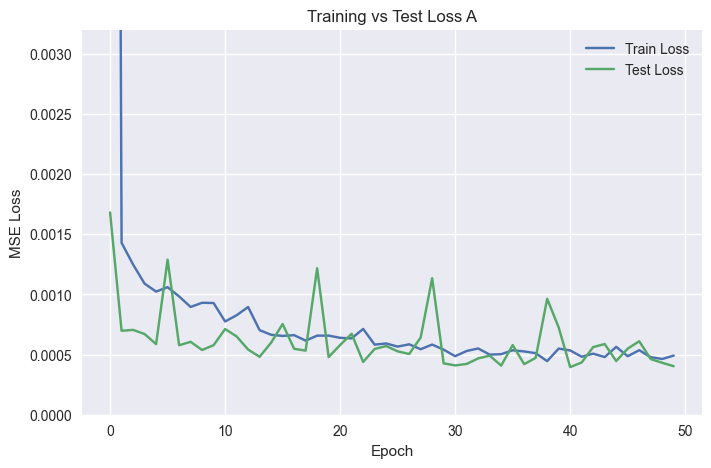

In [136]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Training vs Test Loss {target_ticker}")
plt.ylim(0, 0.0032)
plt.legend()
plt.show()



In [137]:
# Load best model and evaluate
model.load_state_dict(torch.load(f'best_lstm_{target_ticker}.pth'))

train_loss, y_train_true_scaled, y_train_pred_scaled = evaluate_model(
    model, train_loader, criterion, device
)
test_loss, y_test_true_scaled, y_test_pred_scaled = evaluate_model(
    model, test_loader, criterion, device
)

# Inverse transform using target_scaler
y_train_true = target_scaler.inverse_transform(y_train_true_scaled.reshape(-1, 1)).flatten()
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_true  = target_scaler.inverse_transform(y_test_true_scaled.reshape(-1, 1)).flatten()
y_test_pred  = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate multiple metrics
train_rmse = math.sqrt(mean_squared_error(y_train_true, y_train_pred))
test_rmse  = math.sqrt(mean_squared_error(y_test_true,  y_test_pred))

train_mae = np.mean(np.abs(y_train_true - y_train_pred))
test_mae = np.mean(np.abs(y_test_true - y_test_pred))

train_mape = np.mean(np.abs((y_train_true - y_train_pred) / y_train_true)) * 100
test_mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100

print("=" * 60)
print(f"Performance Metrics for {target_ticker}")
print("=" * 60)
print(f"Train RMSE: ${train_rmse:.4f} | Test RMSE: ${test_rmse:.4f}")
print(f"Train MAE:  ${train_mae:.4f} | Test MAE:  ${test_mae:.4f}")
print(f"Train MAPE: {train_mape:.2f}%  | Test MAPE: {test_mape:.2f}%")
print("=" * 60)


Performance Metrics for A
Train RMSE: $1.7996 | Test RMSE: $2.9032
Train MAE:  $1.2102 | Test MAE:  $2.1608
Train MAPE: 1.48%  | Test MAPE: 1.67%


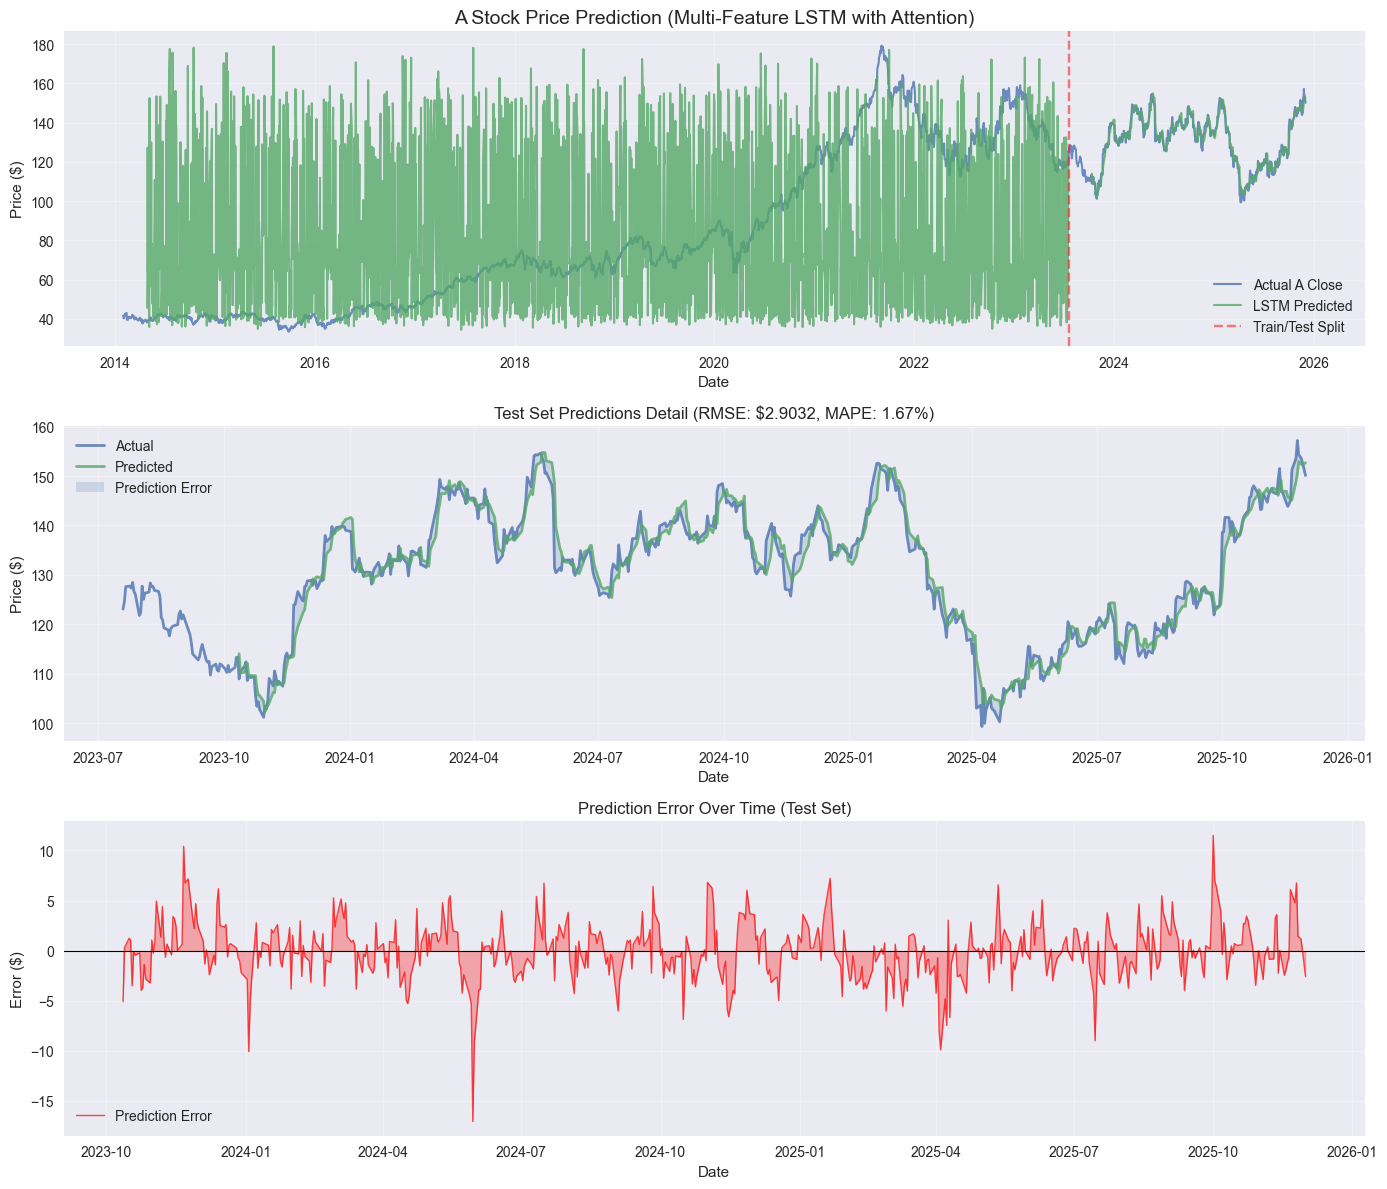

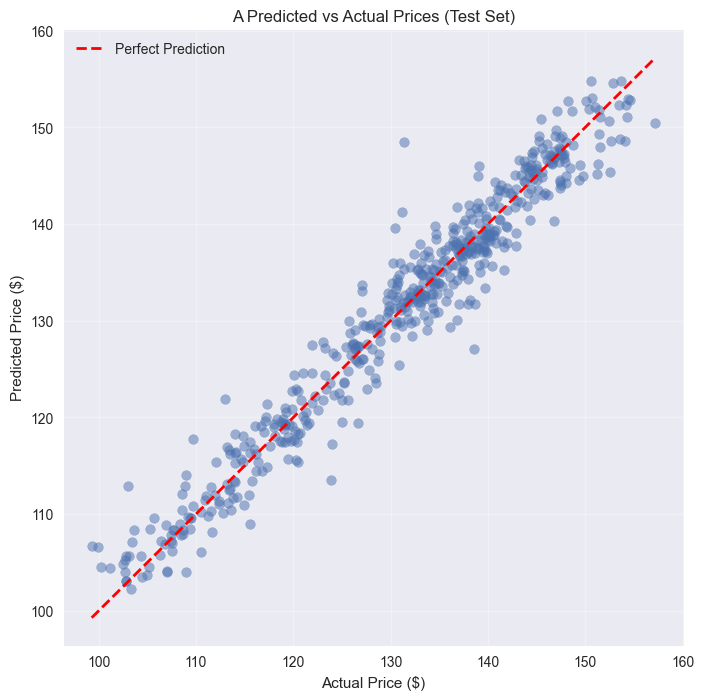

In [138]:
# Enhanced Visualization with Error Metrics

# Get actual prices (before feature engineering dropped some rows)
actual_prices_full = stock_df['Close'].values
dates_full = stock_df['Date'].values

train_full_len = train_size
test_full_len = len(stock_df) - train_size

# Train predictions occupy indices [n_past, train_full_len-1] in the train segment
train_pred_plot = np.empty(train_full_len)
train_pred_plot[:] = np.nan
train_pred_plot[n_past:] = y_train_pred

# Test predictions occupy indices [n_past, test_full_len-1] in the test segment
test_pred_plot = np.empty(test_full_len)
test_pred_plot[:] = np.nan
test_pred_plot[n_past:] = y_test_pred

full_pred = np.empty_like(actual_prices_full)
full_pred[:] = np.nan
full_pred[:train_full_len] = train_pred_plot
full_pred[train_full_len:] = test_pred_plot

# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Full predictions
axes[0].plot(dates_full, actual_prices_full, label=f"Actual {target_ticker} Close", linewidth=1.5, alpha=0.8)
axes[0].plot(dates_full, full_pred, label=f"LSTM Predicted", linewidth=1.5, alpha=0.8)
axes[0].axvline(x=dates_full[train_full_len], color='red', linestyle='--', label='Train/Test Split', alpha=0.5)
axes[0].set_title(f"{target_ticker} Stock Price Prediction (Multi-Feature LSTM with Attention)", fontsize=14)
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Test set detail
test_dates = dates_full[train_full_len:]
test_actual = actual_prices_full[train_full_len:]
test_pred_values = full_pred[train_full_len:]

axes[1].plot(test_dates, test_actual, label="Actual", linewidth=2, alpha=0.8)
axes[1].plot(test_dates, test_pred_values, label="Predicted", linewidth=2, alpha=0.8)
axes[1].fill_between(test_dates, test_actual, test_pred_values, alpha=0.2, label='Prediction Error')
axes[1].set_title(f"Test Set Predictions Detail (RMSE: ${test_rmse:.4f}, MAPE: {test_mape:.2f}%)", fontsize=12)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price ($)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Prediction error over time
test_dates_valid = test_dates[n_past:]
prediction_error = y_test_true - y_test_pred

axes[2].plot(test_dates_valid, prediction_error, label="Prediction Error", color='red', linewidth=1, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[2].fill_between(test_dates_valid, prediction_error, 0, alpha=0.3, color='red')
axes[2].set_title("Prediction Error Over Time (Test Set)", fontsize=12)
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Error ($)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test_true, y_test_pred, alpha=0.5)
plt.plot([y_test_true.min(), y_test_true.max()], 
         [y_test_true.min(), y_test_true.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'{target_ticker} Predicted vs Actual Prices (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [144]:
def forecast_future_to_date(
    date_str,
    model,
    feature_scaler,
    target_scaler,
    feature_columns,
    stock_df,
    n_past,
    device,
    max_horizon_days=60,
):
    """
    Forecast stock prices forward day-by-day until the target date.
    
    Args:
        date_str        : "YYYY-MM-DD" target date
        model           : trained LSTM model
        feature_scaler  : MinMaxScaler for features
        target_scaler   : MinMaxScaler for target (Close price)
        feature_columns : list of feature names
        stock_df        : historical DataFrame with all features
        n_past          : lookback window size
        device          : torch.device
        max_horizon_days: maximum business days to forecast
    
    Returns:
        future_dates : list of forecasted dates
        future_prices: list of forecasted prices (inverse transformed)
    """
    target_date = pd.to_datetime(date_str).normalize()
    last_historical_date = pd.to_datetime(stock_df['Date'].iloc[-1]).normalize()
    
    # Check if target date is too far in the future
    business_days_needed = pd.bdate_range(start=last_historical_date + pd.Timedelta(days=1), 
                                          end=target_date).size
    
    if business_days_needed > max_horizon_days:
        raise ValueError(f"Target date {date_str} is {business_days_needed} business days away, "
                        f"exceeds max_horizon_days={max_horizon_days}")
    
    if business_days_needed == 0:
        raise ValueError(f"Target date {date_str} is not after the last historical date")
    
    # Get the last n_past days of historical data
    last_n_days = stock_df.tail(n_past).copy()
    
    # Initialize forecast sequence
    forecast_df = last_n_days.copy()
    future_dates = []
    future_prices = []
    
    # Generate business days from last date to target date
    business_days = pd.bdate_range(start=last_historical_date + pd.Timedelta(days=1), 
                                   end=target_date)
    
    model.eval()
    
    with torch.no_grad():
        for forecast_date in business_days:
            # Get the last n_past rows for prediction
            sequence_df = forecast_df.tail(n_past)[feature_columns].copy()
            
            # Forward-fill any NaN values in features (from rolling calculations)
            sequence_df = sequence_df.ffill().bfill()
            
            # If there are still NaN values, use the last valid value
            if sequence_df.isna().any().any():
                sequence_df = sequence_df.fillna(sequence_df.iloc[-1])
            
            sequence_data = sequence_df.values
            
            # Check for any remaining NaN or inf values
            if np.isnan(sequence_data).any() or np.isinf(sequence_data).any():
                raise ValueError(f"NaN or Inf values found in sequence data before scaling")
            
            # Scale the features
            sequence_scaled = feature_scaler.transform(sequence_data)
            
            # Check for NaN after scaling
            if np.isnan(sequence_scaled).any() or np.isinf(sequence_scaled).any():
                raise ValueError(f"NaN or Inf values found in scaled sequence data")
            
            # Convert to tensor and add batch dimension
            sequence_tensor = torch.from_numpy(sequence_scaled).float().unsqueeze(0).to(device)
            
            # Predict (output is scaled)
            pred_scaled = model(sequence_tensor).cpu().numpy()[0]
            
            # Check if prediction is valid
            if np.isnan(pred_scaled) or np.isinf(pred_scaled):
                raise ValueError(f"Model prediction is NaN or Inf")
            
            # Inverse transform to get actual price
            pred_price = target_scaler.inverse_transform([[pred_scaled]])[0, 0]
            
            # Check if inverse transform produced valid value
            if np.isnan(pred_price) or np.isinf(pred_price):
                raise ValueError(f"Inverse transformed price is NaN or Inf")
            
            # For Volume, use the average of last 20 days (or last known if not enough data)
            last_volumes = forecast_df['Volume'].tail(20).values
            avg_volume = np.mean(last_volumes) if len(last_volumes) > 0 else forecast_df['Volume'].iloc[-1]
            
            # Create new row with forecasted Close
            new_row = forecast_df.iloc[-1].copy()
            new_row['Date'] = forecast_date
            new_row['Close'] = pred_price
            new_row['Volume'] = avg_volume  # Use average volume
            
            # Recalculate features based on updated Close prices
            # We need to append this row and recalculate all features
            temp_df = pd.concat([forecast_df, pd.DataFrame([new_row])], ignore_index=True)
            
            # Recalculate MA20, Volatility, RSI
            temp_df['MA20'] = temp_df['Close'].rolling(window=20).mean()
            temp_df['Daily_Return'] = temp_df['Close'].pct_change(fill_method=None)
            temp_df['Volatility'] = temp_df['Daily_Return'].rolling(window=20).std()
            
            # RSI calculation
            delta = temp_df['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / (loss + 1e-10)  # Avoid division by zero
            temp_df['RSI'] = 100 - (100 / (1 + rs))
            
            # Forward-fill NaN values in calculated features (from rolling windows)
            for col in ['MA20', 'Volatility', 'RSI']:
                if col in temp_df.columns:
                    temp_df[col] = temp_df[col].ffill().bfill()
                    # If still NaN, use the last valid value
                    if temp_df[col].isna().any():
                        last_valid = temp_df[col].dropna()
                        if len(last_valid) > 0:
                            temp_df[col] = temp_df[col].fillna(last_valid.iloc[-1])
                        else:
                            # If no valid values, use a default (0 for Volatility, 50 for RSI, last Close for MA20)
                            if col == 'RSI':
                                temp_df[col] = temp_df[col].fillna(50.0)
                            elif col == 'Volatility':
                                temp_df[col] = temp_df[col].fillna(0.0)
                            else:  # MA20
                                temp_df[col] = temp_df[col].fillna(temp_df['Close'].iloc[-1])
            
            # Get the last row (our forecasted day) with updated features
            new_row_updated = temp_df.iloc[-1].copy()
            
            # Append to forecast_df (keep only last n_past + some buffer for calculations)
            forecast_df = temp_df.tail(n_past + 20).reset_index(drop=True)
            
            # Store results
            future_dates.append(forecast_date)
            future_prices.append(pred_price)
    
    return future_dates, future_prices


In [145]:
def query_price_and_trend(
    date_str,
    full_dates,
    full_closes,
    full_pred_prices,
    target_ticker,
    model,
    feature_scaler,
    target_scaler,
    feature_columns,
    stock_df,
    n_past,
    device,
    max_horizon_days=60,
):
    """
    Query actual vs predicted price and predicted trend for a given date.

    Behavior:
    - If date_str is WITHIN the historical dataset:
        -> Use in-sample predicted prices (full_pred_prices).
    - If date_str is AFTER the last known date:
        -> Forecast forward day-by-day using the LSTM (up to max_horizon_days),
           then report the forecasted price and trend.

    Args:
        date_str        : "YYYY-MM-DD"
        full_dates      : numpy array of datetime64 (historical dates)
        full_closes     : numpy array of actual Close prices (historical)
        full_pred_prices: numpy array of in-sample predicted Close prices (NaNs where unavailable)
        target_ticker   : symbol string, e.g. "A"
        model           : trained LSTM model
        feature_scaler  : MinMaxScaler fitted on feature_columns
        target_scaler   : MinMaxScaler fitted on target (Close price)
        feature_columns : list of feature names used by the model
        stock_df        : original historical DataFrame (Date, Close, Volume, etc.)
        n_past          : lookback window size
        device          : torch.device
        max_horizon_days: max allowed business-day horizon for future forecasts
    """
    target_date = pd.to_datetime(date_str).normalize()

    first_date = pd.to_datetime(full_dates[0]).normalize()
    last_date  = pd.to_datetime(full_dates[-1]).normalize()

    # ---------- Case 1: date before our dataset ----------
    if target_date < first_date:
        print(f"Date {date_str} is before the first available date "
              f"({first_date.date()}) for {target_ticker}.")
        return

    # ---------- Case 2: date is inside the historical dataset ----------
    if target_date <= last_date:
        target_np = np.datetime64(target_date)
        indices = np.where(full_dates == target_np)[0]

        if len(indices) == 0:
            print(f"Date {date_str} not found in the dataset for {target_ticker}.")
            return

        i = indices[0]
        actual_price = full_closes[i]
        pred_price = full_pred_prices[i]

        print(f"=== {target_ticker} on {date_str} (within dataset) ===")
        print(f"Actual close:    {actual_price:.4f}")

        if np.isnan(pred_price):
            print("No LSTM price prediction available for this date "
                  "(likely within the initial window).")
            return

        print(f"Predicted close: {pred_price:.4f}")

        # Trend vs previous day (predicted)
        if i == 0 or np.isnan(full_pred_prices[i - 1]):
            print("Cannot compute predicted trend: missing previous prediction.")
            return

        prev_pred = full_pred_prices[i - 1]
        if pred_price > prev_pred:
            trend = "UP"
        elif pred_price < prev_pred:
            trend = "DOWN"
        else:
            trend = "FLAT"

        pct_change = (pred_price - prev_pred) / (prev_pred + 1e-8) * 100

        print(f"Predicted trend vs previous day: {trend} "
              f"({prev_pred:.4f} → {pred_price:.4f}, {pct_change:.2f}%)")
        return

    # ---------- Case 3: date is AFTER the historical dataset -> FUTURE FORECAST ----------
    print(f"=== {target_ticker} on {date_str} (future forecast) ===")
    print(f"Last known historical date: {last_date.date()}")

    try:
        future_dates, future_prices = forecast_future_to_date(
            date_str=date_str,
            model=model,
            feature_scaler=feature_scaler,
            target_scaler=target_scaler,
            feature_columns=feature_columns,
            stock_df=stock_df,
            n_past=n_past,
            device=device,
            max_horizon_days=max_horizon_days,
        )
    except ValueError as e:
        print("Could not forecast:", e)
        return

    # The forecast for the requested date is the last one in the sequence
    forecast_price = future_prices[-1]

    print(f"Forecasted close: {forecast_price:.4f}")

    # Trend vs previous business day
    if len(future_prices) == 1:
        # Only one predicted step; compare vs last actual historical price
        prev_price = full_closes[-1]
        source_label = "last actual historical price"
    else:
        prev_price = future_prices[-2]
        source_label = "previous forecasted business day"

    if forecast_price > prev_price:
        trend = "UP"
    elif forecast_price < prev_price:
        trend = "DOWN"
    else:
        trend = "FLAT"

    pct_change = (forecast_price - prev_price) / (prev_price + 1e-8) * 100

    print(f"Predicted trend vs {source_label}: {trend} "
          f"({prev_price:.4f} → {forecast_price:.4f}, {pct_change:.2f}%)")

    # (Optional) If you want to see the full forecast path, you could also print:
    # for d, p in zip(future_dates, future_prices):
    #     print(d.date(), "→", f"{p:.4f}")


In [ ]:
print("Testing predictions for different dates:\n")

# # Example 1: Historical date
query_price_and_trend(
    "2020-03-20",
    dates_full,
    actual_prices_full,
    full_pred,
    target_ticker,
    model,
    feature_scaler,
    target_scaler,
    feature_columns,
    stock_df,
    n_past,
    device,
    max_horizon_days=60,
)

# Example 2: Future (e.g., within 30–60 business days after last known date)
query_price_and_trend(
    "2025-12-05",
    dates_full,
    actual_prices_full,
    full_pred,
    target_ticker,
    model,
    feature_scaler,
    target_scaler,
    feature_columns,
    stock_df,
    n_past,
    device,
    max_horizon_days=60,
)


Testing predictions for different dates:

=== A on 2020-03-20 (within dataset) ===
Actual close:    66.4600
Predicted close: 70.6983
Predicted trend vs previous day: DOWN (116.7776 → 70.6983, -39.46%)
=== A on 2025-12-05 (future forecast) ===
Last known historical date: 2025-12-01
Forecasted close: 150.3680
Predicted trend vs previous forecasted business day: UP (149.7827 → 150.3680, 0.39%)
